In [4]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, OneHotEncoder, OrdinalEncoder
import sklearn
import xgboost
from joblib import dump
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore') 

In [ ]:
class DataProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.standard_scaler = StandardScaler()
        self.yeo_johnson = PowerTransformer(method='yeo-johnson', standardize=True)
        self.one_hot_encoder = None
        self.ordinal_encoder = None
        self.loo_encodings = {}
        self.median_visibility = None
        self.item_weight_medians = {}
        self.outlet_size_modes = {}

    def fit(self, X, y=None):
        # Handle missing Item_Weight
        self.item_weight_medians = X.groupby('Item_Type')['Item_Weight'].median().to_dict()

        # Handle missing Outlet_Size
        self.outlet_size_modes = X.groupby('Outlet_Type')['Outlet_Size'].agg(
            lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
        ).to_dict()

        # Replace zero visibility with median visibility
        non_zero_visibility = X.loc[X['Item_Visibility'] > 0, 'Item_Visibility']
        self.median_visibility = non_zero_visibility.median()

        # Fit scalers for numerical columns
        self.scaler.fit(X[['Item_MRP']])
        self.standard_scaler.fit(X[['Item_Weight', 'Item_Visibility']])

        # Fit Yeo-Johnson for skewed features
        skewed_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
        self.yeo_johnson.fit(X[skewed_columns])

        # Fit one-hot encoder for low-cardinality categorical features
        low_cardinality_features = ['Outlet_Type']
        self.one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.one_hot_encoder.fit(X[low_cardinality_features])

        # Fit ordinal encoder for features with hierarchy
        ordinal_features = ['Outlet_Size', 'Outlet_Location_Type']
        self.ordinal_encoder = OrdinalEncoder(categories=[
            ['Small', 'Medium', 'High'],  # Outlet_Size
            ['Tier 3', 'Tier 2', 'Tier 1']  # Outlet_Location_Type
        ], handle_unknown='use_encoded_value', unknown_value=-1)
        self.ordinal_encoder.fit(X[ordinal_features])

        # Calculate LOO encoding for high cardinality features, excluding 'Item_Type'
        if y is not None:
            y = pd.Series(y, index=X.index)
            high_cardinality_features = ['Item_Identifier', 'Outlet_Identifier']
            for feature in high_cardinality_features:
                loo_encoding = X.groupby(feature).apply(lambda group: y.loc[group.index].mean()).to_dict()
                self.loo_encodings[feature] = loo_encoding

        return self

    def transform(self, X, y=None):
        X = X.copy()

        # Check required columns
        required_columns = ['Item_Type', 'Item_Weight', 'Item_Visibility', 'Item_MRP', 
                            'Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size']
        for col in required_columns:
            if col not in X.columns:
                raise KeyError(f"The column '{col}' is missing from the input data.")

        # Handle missing values and preprocessing
        X['Item_Weight'] = X['Item_Weight'].fillna(X['Item_Type'].map(self.item_weight_medians))
        X['Outlet_Size'] = X['Outlet_Size'].fillna(X['Outlet_Type'].map(self.outlet_size_modes))
        X['Item_Visibility'] = X['Item_Visibility'].replace(0, self.median_visibility)

        # Normalize and map Item_Fat_Content
        X['Item_Fat_Content'] = X['Item_Fat_Content'].str.strip().str.lower()
        fat_content_map = {'low fat': 'Low Fat', 'lf': 'Low Fat', 'regular': 'Regular', 'reg': 'Regular'}
        X['Item_Fat_Content'] = X['Item_Fat_Content'].map(fat_content_map)

        # One-hot encode Item_Fat_Content
        one_hot = pd.get_dummies(X['Item_Fat_Content'], prefix='Item_Fat_Content')
        X = pd.concat([X.drop(columns=['Item_Fat_Content']), one_hot], axis=1)

        # Outlier capping
        continuous_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
        z_threshold = 3
        for col in continuous_columns:
            upper_bound = X[col].mean() + z_threshold * X[col].std()
            lower_bound = X[col].mean() - z_threshold * X[col].std()
            X[col] = np.clip(X[col], lower_bound, upper_bound)

        # Apply transformations
        skewed_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
        X[skewed_columns] = self.yeo_johnson.transform(X[skewed_columns])
        X[['Item_Weight', 'Item_Visibility']] = self.standard_scaler.transform(X[['Item_Weight', 'Item_Visibility']])
        X[['Item_MRP']] = self.scaler.transform(X[['Item_MRP']])

        # Encode Outlet_Type
        low_cardinality_features = ['Outlet_Type']
        encoded_features = self.one_hot_encoder.transform(X[low_cardinality_features])
        encoded_features = pd.DataFrame(
            encoded_features,
            columns=self.one_hot_encoder.get_feature_names_out(low_cardinality_features),
            index=X.index
        )
        X = pd.concat([X, encoded_features], axis=1).drop(columns=low_cardinality_features)

        # Encode hierarchical features
        ordinal_features = ['Outlet_Size', 'Outlet_Location_Type']
        X[ordinal_features] = self.ordinal_encoder.transform(X[ordinal_features])

        # One-hot encode 'Item_Type'
        one_hot_item_type = pd.get_dummies(X['Item_Type'], prefix='Item_Type')
        X = pd.concat([X.drop(columns=['Item_Type']), one_hot_item_type], axis=1)

        # LOO encoding for high cardinality, excluding 'Item_Type'
        high_cardinality_features = ['Outlet_Identifier']
        for feature in high_cardinality_features:
            if feature in X.columns:
                X[f'{feature}_LOO'] = X[feature].map(self.loo_encodings.get(feature, {})).fillna(0)

        X.drop(columns=high_cardinality_features, inplace=True)
        

        # Add new feature engineering
        X['Outlet_Age'] = 2024 - X['Outlet_Establishment_Year']
        X['Visibility_Percentage'] = X['Item_Visibility'] / (X['Item_Visibility'].sum() + 1e-5)
        X['Price_Per_Weight'] = X['Item_MRP'] / (X['Item_Weight'] + 1e-5)
        X['Visibility_to_MRP_Ratio'] = X['Item_Visibility'] / (X['Item_MRP'] + 1e-5)
        X['Discount_Potential'] = X['Item_MRP'] / (X['Item_Visibility'] + 1e-5)

        # Remove spaces in column names
        X.columns = X.columns.str.replace(' ', '_')
        X.drop(columns=['Item_Identifier','Outlet_Establishment_Year'], inplace=True)

        return X

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

data = pd.read_csv('C:\\Users\\anjan\\download\\Documents\\Train.csv')
target_variable = 'Item_Outlet_Sales'
X = data.drop(columns=[target_variable])
y = data[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

processor = DataProcessor()
X_train = processor.fit_transform(X_train, y_train)
X_test = processor.transform(X_test)

print("Training data missing values:\n", X_train.isnull().sum())
print("Testing data missing values:\n", X_test.isnull().sum())


Training data missing values:
 Item_Weight                        0
Item_Visibility                    0
Item_MRP                           0
Outlet_Size                        0
Outlet_Location_Type               0
Item_Fat_Content_Low_Fat           0
Item_Fat_Content_Regular           0
Outlet_Type_Grocery_Store          0
Outlet_Type_Supermarket_Type1      0
Outlet_Type_Supermarket_Type2      0
Outlet_Type_Supermarket_Type3      0
Item_Type_Baking_Goods             0
Item_Type_Breads                   0
Item_Type_Breakfast                0
Item_Type_Canned                   0
Item_Type_Dairy                    0
Item_Type_Frozen_Foods             0
Item_Type_Fruits_and_Vegetables    0
Item_Type_Hard_Drinks              0
Item_Type_Health_and_Hygiene       0
Item_Type_Household                0
Item_Type_Meat                     0
Item_Type_Others                   0
Item_Type_Seafood                  0
Item_Type_Snack_Foods              0
Item_Type_Soft_Drinks              0
Item_Ty

In [ ]:
from joblib import dump

# Specify the path where you want to save the files
path = r'C:\Users\\download\Desktop\UI\\'

# Save each part separately after fitting
dump(processor.scaler, path + 'scaler.pkl')
dump(processor.standard_scaler, path + 'standard_scaler.pkl')
dump(processor.yeo_johnson, path + 'yeo_johnson.pkl')
dump(processor.one_hot_encoder, path + 'one_hot_encoder.pkl')
dump(processor.ordinal_encoder, path + 'ordinal_encoder.pkl')
dump(processor.loo_encodings, path + 'loo_encodings.pkl')
dump(processor.item_weight_medians, path + 'item_weight_medians.pkl')
dump(processor.outlet_size_modes, path + 'outlet_size_modes.pkl')
dump(processor.median_visibility, path + 'median_visibility.pkl')

print("All parts saved to the specified path.")


All parts saved to the specified path.


In [8]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, verbosity=0),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                                   max_iter=1000, random_state=42)
}

# Train and evaluate models
r2_scores = {'Model': [], 'Training R²': [], 'Testing R²': []}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Convert X_train to numpy if necessary for XGBoost
    if model_name == 'XGBoost':
        X_train_data, X_test_data = X_train.to_numpy(), X_test.to_numpy()
    else:
        X_train_data, X_test_data = X_train, X_test

    
    model.fit(X_train_data, y_train)
    
    
    train_preds = model.predict(X_train_data)
    test_preds = model.predict(X_test_data)
    
    # R² Scores
    r2_scores['Model'].append(model_name)
    r2_scores['Training R²'].append(r2_score(y_train, train_preds))
    r2_scores['Testing R²'].append(r2_score(y_test, test_preds))

r2_scores_df = pd.DataFrame(r2_scores)

print("\nModel Performance (R² Scores):")
print(r2_scores_df)


Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...
Training MLP Regressor...

Model Performance (R² Scores):
               Model  Training R²  Testing R²
0  Linear Regression     0.562106    0.578638
1      Random Forest     0.723045    0.606711
2  Gradient Boosting     0.670230    0.597786
3            XGBoost     0.813836    0.572002
4      MLP Regressor     0.233134    0.261973


In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define XGBoost hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 1, 5],
    'reg_lambda': [1, 5, 10],
}

# Initialize XGBRegressor
xgb = XGBRegressor(random_state=42, verbosity=0)

# Perform RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=50,
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print("Tuning XGBoost...")
xgb_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb = xgb_search.best_estimator_
print(f"Best Params for XGBoost: {xgb_search.best_params_}")
print(f"Best CV R² for XGBoost: {xgb_search.best_score_:.4f}")

# Evaluate XGBoost on train and test sets
xgb_train_r2 = best_xgb.score(X_train, y_train)
xgb_test_r2 = best_xgb.score(X_test, y_test)
print(f"XGBoost Training R²: {xgb_train_r2:.4f}")
print(f"XGBoost Testing R²: {xgb_test_r2:.4f}")

Tuning XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params for XGBoost: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 5, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.8}
Best CV R² for XGBoost: 0.5971
XGBoost Training R²: 0.6283
XGBoost Testing R²: 0.6196


In [ ]:
import pickle
X_train_np = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
X_test_np = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test

# Ensure y_train and y_test are NumPy arrays
y_train_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
y_test_np = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

# Best Parameters from Hyperparameter Tuning
best_params = {
    'subsample': 1.0,
    'reg_lambda': 5,
    'reg_alpha': 0,
    'n_estimators': 500,
    'max_depth': 4,
    'learning_rate': 0.01,
    'gamma': 5,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'verbosity': 0,
    'enable_categorical': True  # Ensure proper handling if using categorical data
}

# Retrain the XGBoost Model
print("Retraining XGBoost with best parameters...")
best_xgb = XGBRegressor(**best_params)
best_xgb.fit(X_train_np, y_train_np)

# Evaluate on Training and Test Sets
xgb_train_r2 = best_xgb.score(X_train_np, y_train_np)
xgb_test_r2 = best_xgb.score(X_test_np, y_test_np)

print(f"XGBoost Retrained Training R²: {xgb_train_r2:.4f}")
print(f"XGBoost Retrained Testing R²: {xgb_test_r2:.4f}")

# Save the Retrained Model
model_path = r'C:\Users\anjan\download\Desktop\UI\best_xgb_model.pkl'

# Save the model using pickle
with open(model_path, 'wb') as f:
    pickle.dump(best_xgb, f)

print(f"XGBoost model saved to {model_path}")


In [ ]:
model_path = r'C:\Users\anjan\download\Desktop\UI\best_xgb_model.pkl'
model = joblib.load(model_path)

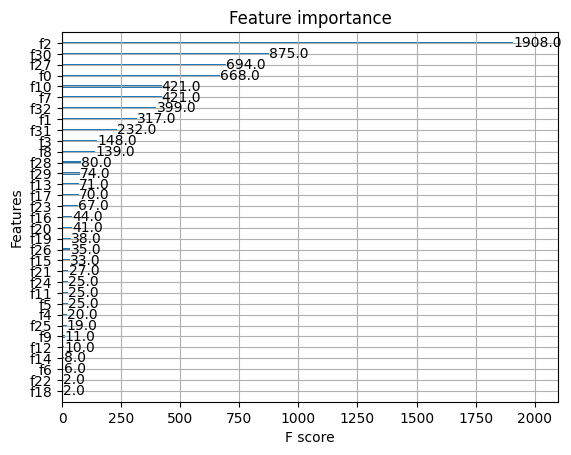

In [19]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Access the booster (core XGBoost model) from the XGBRegressor
booster = model.get_booster()

# Plot feature importance
xgb.plot_importance(booster)
plt.show()

In [20]:
importance = booster.get_score(importance_type='weight')  # Can also use 'gain' or 'cover'

# Convert to DataFrame for better readability
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Save the importance DataFrame to a CSV file
importance_df.to_csv('feature_importances.csv', index=False)

# Display the top 10 features
print(importance_df.head(10))

   Feature  Importance
2       f2      1908.0
30     f30       875.0
27     f27       694.0
0       f0       668.0
7       f7       421.0
10     f10       421.0
32     f32       399.0
1       f1       317.0
31     f31       232.0
3       f3       148.0


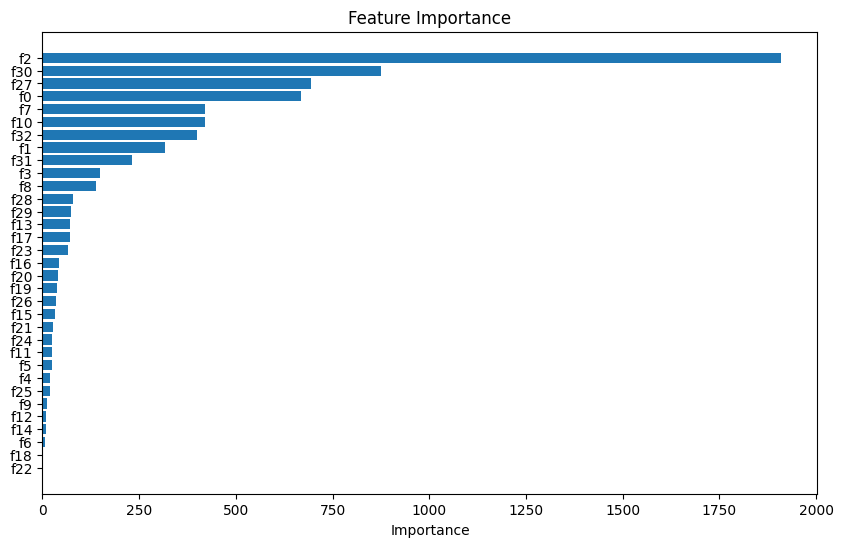

In [21]:
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top
plt.show()

In [ ]:
import joblib
model = joblib.load(r'C:\Users\anjan\download\Desktop\UI\best_xgb_model.pkl')

# If you used XGBoost, this might help
try:
    feature_names = model.get_booster().feature_names
    print("Feature Names:")
    for i, name in enumerate(feature_names, 1):
        print(f"{i}. {name}")
    print(f"\nTotal Features: {len(feature_names)}")
except:
    print("Could not retrieve feature names directly from the model.")

# Alternate method if the above doesn't work
try:
    # If you trained on a DataFrame, this might work
    feature_names = model.feature_names_in_
    print("\nAlternate Feature Names:")
    for i, name in enumerate(feature_names, 1):
        print(f"{i}. {name}")
except:
    print("Could not retrieve feature names using alternate method.")

Feature Names:
Could not retrieve feature names directly from the model.
Could not retrieve feature names using alternate method.


In [ ]:
import joblib
import pickle

# Method 1: Direct inspection
model = joblib.load(r'C:\Users\anjan\download\Desktop\UI\best_xgb_model.pkl')

print("Model Type:", type(model))
print("\nModel Attributes:")
print(dir(model))

# Method 2: If it's an sklearn pipeline or similar
try:
    print("\nSteps in Pipeline (if applicable):")
    print(model.steps)
except:
    print("Not a pipeline model")

# Method 3: More detailed inspection
try:
    print("\nModel Parameters:")
    print(model.get_params())
except:
    print("Could not retrieve model parameters")

Model Type: <class 'xgboost.sklearn.XGBRegressor'>

Model Attributes:
['_Booster', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__sklearn_is_fitted__', '__str__', '__subclasshook__', '__weakref__', '_build_request_for_signature', '_can_use_inplace_predict', '_check_feature_names', '_check_n_features', '_configure_fit', '_create_dmatrix', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_estimator_type', '_get_default_requests', '_get_doc_link', '_get_iteration_range', '_get_metadata_request', '_get_param_names', '_get_tags', '_get_type', '_load_model_attributes', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_set_evaluation_result', 

In [5]:
try:
    feature_names = model.get_booster().feature_names
    print("Booster Feature Names:", feature_names)
except Exception as e:
    print("Could not retrieve feature names from booster:", e)

# Additional diagnostic information
print("\nModel Details:")
print("Total Features Expected:", model.n_features_in_)
print("Number of Estimators:", model.n_estimators)
print("Learning Rate:", model.learning_rate)

Booster Feature Names: None

Model Details:
Total Features Expected: 33
Number of Estimators: 500
Learning Rate: 0.01
